In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha=0.1):
    return np.maximum(x, x * alpha)

def leaky_relu_deriv(x, alpha=0.1):
    dx = np.ones_like(x)
    dx[alpha < 0] = alpha
    return dx

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

def mse_loss(y_hat, y):
    return np.sum((y_hat - y)**2) / y_hat.shape[0]

def mse_loss_deriv(y_hat, y):
    return 2 * (y_hat - y) / y_hat.shape[0]

def binary_crossentropy(y, y_hat):
    epsilon = 1e-7  # to avoid division by zero errors
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)  # clip values to avoid NaNs
    loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return np.mean(loss)


In [2]:

class NumpyNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = sigmoid(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output):
        self.dz2 = mse_loss_derivative(y, output) * sigmoid_prime(self.z2)
        self.dW2 = self.a1.T @ self.dz2
        self.db2 = np.sum(self.dz2, axis=0)

        self.dz1 = self.dz2 @ self.W2.T * sigmoid_prime(self.z1)
        self.dW1 = X.T @ self.dz1
        self.db1 = np.sum(self.dz1, axis=0)

        self.W1 -= learning_rate * self.dW1
        self.W2 -= learning_rate * self.dW2
        self.b1 -= learning_rate * self.db1
        self.b2 -= learning_rate * self.db2

    def train(self, batch, epochs, learning_rate):
        for _ in range(epochs):
            for X, y in batch:
                output = self.forward(X)
                self.backward(X, y, output)


In [3]:
# class BookNN:
#     def __init__(self, sizes):
#         self.num_layers = len(sizes)
#         self.sizes = sizes
#         self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
#         self.weights = [np.random.randn(x, y) for x, y in zip(sizes[:-1], sizes[1:])]        
    
#     def forward(self, a):
#         for b, w in zip(self.biases, self.weights):
#             a = sigmoid(a @ w + b)
#         return a
    
#     def backprop(self, x, y):
#         nabla_b = [np.zeros(b.shape) for b in self.biases]
#         nabla_w = [np.zeros(w.shape) for w in self.weights]

#         # feedforward
#         activation = x
#         activations = [x] # list to store all the activations, layer by layer
#         zs = [] # list to store all the z vectors, layer by layer
#         for b, w in zip(self.biases, self.weights):
#             z = activation @ w + b
#             zs.append(z)
#             activation = sigmoid(z)
#             activations.append(activation)

#         print('>>', activations)
            
#         # backward pass
#         delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
#         nabla_b[-1] = delta
#         nabla_w[-1] = activations[-2].transpose() @ delta
#         print(delta.shape)
       
#         for l in range(2, self.num_layers):
#             z = zs[-l]
#             sp = sigmoid_prime(z)
#             delta = (self.weights[-l+1].transpose() @ delta) * sp
#             print(delta.shape)
#             nabla_b[-l] = delta
#             nabla_w[-l] = (activations[-l-1].transpose() @ delta)
#         return (nabla_b, nabla_w)
                
#     def update_batch(self, batch):
#         for x, y in batch:
#             print(x, y)
#             (nabla_b, nabla_w) = self.backprop(x, y)
#             print(nabla_b, nabla_w)

#     def sgd(self, training_data, epochs, mini_batch_size):
#         n = len(training_data)
#         for j in range(epochs):
#             random.shuffle(training_data)
#             mini_batches = [
#                 training_data[k:k+mini_batch_size]
#                 for k in range(0, len(training_data), mini_batch_size)]
#             for batch in mini_batches:
#                 self.update_batch(batch)


# dL/a2 = mse_loss'(a2, y)
# dL/z2 = relu'(z2) * da2
# dL/b2 = 1 * dL/z2
# dL/w2 = a1 * dL/z2
# dL/a1 = w2 * dL/z2
# dL/z1 = relu'(z1) * dL/a1
# dL/w1 = a0 * dL/z1
# dL/b1 = 1 * dL/z1


In [50]:
class FFN:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.zeros((1, k)) for k in sizes[1:]]
        self.weights = [np.random.randn(x, y) * 0.01 for x, y in zip(sizes[:-1], sizes[1:])]
    
    def act(self, x):
#         return relu(x)
        return leaky_relu(x)
#         return sigmoid(x)
    
    def act_deriv(self, x):
#         return relu_deriv(x)
        return leaky_relu_deriv(x)
#         return sigmoid_prime(x)
    
    def forward(self, x):
        act = x
        for w, b in zip(self.weights, self.biases):
            act = self.act(act @ w + b)
        return act

    def backward(self, x, y, debug=False):
        eta = 1e-3

        zs = []
        act = x
        acts = [act]
        for w, b in zip(self.weights, self.biases):
            z = act @ w + b
            if debug:
                print(f'{z=} = {act=} @ {w=} + {b=}')
            zs.append(z)
            act = self.act(z)
            acts.append(act)

        dbs = [np.zeros(b.shape) for b in self.biases]
        dws = [np.zeros(w.shape) for w in self.weights]

        delta = mse_loss_deriv(acts[-1], y)
        for l in range(1, self.num_layers):
            dz = self.act_deriv(zs[-l]) * delta
            db = np.sum(dz, axis=0, keepdims=True)
            dbs[-l] = db
            dw = acts[-l-1].T @ dz
            dws[-l] = dw
            delta = dz @ self.weights[-l].T
        
        if debug:
            print(f'{dws}')
        for i in range(len(dws)):
            self.weights[i] -= eta * dws[i]
            self.biases[i] -= eta * dbs[i]
        

x_train = np.array([1])
y_train = np.array([10])

nn = FFN([1, 2, 1])
losses = []
for n in range(1000):
    y_hat = nn.forward(x_train)
    loss = mse_loss(y_hat, y_train)
    losses.append(loss)
    if n%100 == 0:
        print(f'\n{n}: {loss=}')
    if abs(loss) < 0.01:
        break
    nn.backward(x_train, y_train, n%100==0)



0: loss=99.99994136145503
z=array([[-0.00098733, -0.0045554 ]]) = act=array([1]) @ w=array([[-0.00098733, -0.0045554 ]]) + b=array([[0., 0.]])
z=array([[2.93192768e-06]]) = act=array([[-9.87331395e-05, -4.55539941e-04]]) @ w=array([[ 0.00541585],
       [-0.00760998]]) + b=array([[0.]])
[array([-0.10831701,  0.15219964]), array([[0.00197466],
       [0.0091108 ]])]

100: loss=66.98451740817778
z=array([[ 0.04210969, -0.03676253]]) = act=array([1]) @ w=array([[ 0.02056118, -0.02065897]]) + b=array([[ 0.02154851, -0.01610357]])
z=array([[1.81559303]]) = act=array([[ 0.04210969, -0.00367625]]) @ w=array([[ 0.03023438],
       [-0.01113885]]) + b=array([[1.81427892]])
[array([-0.49490097,  0.1823298 ]), array([[-0.68928561],
       [ 0.06017591]])]

200: loss=43.873853901410655
z=array([[ 0.33732789, -0.08042115]]) = act=array([1]) @ w=array([[ 0.16817028, -0.04248827]]) + b=array([[ 0.16915761, -0.03793287]])
z=array([[3.37626586]]) = act=array([[ 0.33732789, -0.00804211]]) @ w=array([[ 

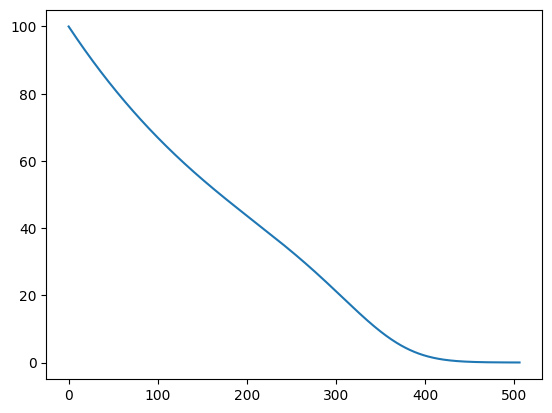

In [49]:
plt.plot(losses)
plt.show()

In [83]:
        

def forward(X, params):
    W1, b1, W2, b2 = params
    Z1 = X @ W1 + b1
    A1 = sigmoid(Z1)
    Z2 = A1 @ W2 + b2
    A2 = sigmoid(Z2)
    return (Z1, A1, Z2, A2)


def backward(X, y, params, cache):
    W1, b1, W2, b2 = params
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]
    
    dZ2 = A2 - y
    dW2 = A1.T @ dZ2 / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    dZ1 = dZ2 @ W2.T * sigmoid_prime(Z1)
    dW1 = X.T @ dZ1 / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    W1 -= eta * dW1
    b1 -= eta * db1
    W2 -= eta * dW2
    b2 -= eta * db2    
    return (W1, b1, W2, b2)


input_size = 1
hidden_size = 2
output_size = 1

W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

eta = 0.01
epochs = 10000

X = np.random.randn(1000, input_size) * 100
y = (X >= 0).astype(int)
batch_size = 100

params = (W1, b1, W2, b2)
for i in range(epochs):
    #random.shuffle(train)
    for k in range(0, len(X), batch_size):
        x_train = X[k:k+batch_size]
        y_true = y[k:k+batch_size]
        cache = forward(x_train, params)
        Z1, A1, Z2, A2 = cache
        loss = binary_crossentropy(y_true, A2)
        params = backward(x_train, y_true, params, cache)
    if i % 1000 == 0:
        print(f'epoch {i}: {loss=}')

x_test = (np.arange(100) - 50).reshape(-1, 1)
# x_test = np.array([-100, -2, 0, 1, 5, 5, 6]).reshape(-1, 1)
y_test = (x_test >= 0).astype(int)
_, _, _, predictions = forward(x_test, params)
predictions_rounded = np.round(predictions)
print(f"input: {x_test.ravel()}")
print(f"true labels: {y_test.ravel()}")
print(f"predictions: {predictions.ravel()}")
print(f"predictions rounded: {predictions_rounded.ravel()}")


epoch 0: loss=0.6911425945002256
epoch 1000: loss=0.03498663982095784
epoch 2000: loss=0.022971658205108273
epoch 3000: loss=0.019153514786408338
epoch 4000: loss=0.017303504863895626
epoch 5000: loss=0.016190988197508905
epoch 6000: loss=0.01542403467753242
epoch 7000: loss=0.014844294022325287
epoch 8000: loss=0.014377269559741493
epoch 9000: loss=0.013983905839661599
input: [-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49]
true labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1